# Самостоятельная работа № 1

### Задание 1

Модуль лингвистической предобработки текста является одним из важнейших компонентов современных TTS систем.
Стандартный набор преобразований над текстом включает в себя:
- нормализацию;
- токенизацию;
- построение транскрипции.

Нормализация подразумевает расшифровку числовых последовательностей, дат, аббревиатур, иноязычных вставок, сокращений и так далее (не путать с приведением к нормальной форме слов — принятой терминологиией в NLP).

Токенизация — разбиение текста на предложения и слова.

Построение транскрипции позволяет получить из графемного представления текста фонемное. На этом же этапе разрешается проблема расстановки ударений. 

Предлагается построить простой пайплайн лингвистической предобработки: токенизация на предложения, нормализация каждого предложения, получение фонемной последовательности для каждого предложения.

### Инструкция по установке и подключению сторонних библиотек из репозиториев (если не устанавливается через pip)
1. Склонировать репозиторий:

*!git clone путь\_к\_репозиторию*

2. Добавить корень репозитория в $PATH:

*sys.path.append("корень\_склонированного\_репо")*

3. Установить необходимые зависимости для репозитория:

*!pip install название\_библиотеки*

In [1]:
# Установка необходимых библиотек
!pip install -q gdown razdel torch

# F*ck this rnnmorph maintainer...
!pip install -q --force-reinstall 'tensorflow>=1.1.0,<2.0' 'keras>=2.1.4,<2.4.0'

     |████████████████████████████████| 110.5 MB 699 bytes/s 
     |████████████████████████████████| 377 kB 56.4 MB/s 
     |████████████████████████████████| 503 kB 49.6 MB/s 
     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 20.1 MB 10.6 MB/s 
     |████████████████████████████████| 131 kB 60.9 MB/s 
     |████████████████████████████████| 3.8 MB 47.0 MB/s 
     |████████████████████████████████| 2.9 MB 47.2 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 42.6 MB/s 
     |████████████████████████████████| 3.9 MB 41.9 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 636 kB 27.0 MB/s 
     |████████████████████████████████| 28.5 MB 50 kB/s 
     |████████████████████████████████| 288 kB 59.0 MB/s 
     |████████████████████████████████| 946 kB 56.2 MB/s 
     |████████████

In [2]:
# Импорт необходимых библиотек
import os
import sys
import uuid
import warnings
import IPython.display as ipd

import gdown
import librosa
import numpy as np
import torch
from google.colab import files
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
# user ID:
my_id = uuid.uuid4().hex
print(my_id)

5d9b47af43f84fddbf1c2d71a38eac5f


In [5]:
# Исходный текст
input_text = "В 1785 г в городе Augsburg случилось странное происшествие. Группа в 18 человек, где каждый весил не менее 100 кг, устроила праздник на втором этаже деревянного здания."

In [6]:
# Используйте razdel отсюда https://github.com/natasha/razdel
from razdel import sentenize


def tokenize_by_sent(text):
    """Возвращает список токенизированных предложений"""
    return [x.text for x in sentenize(text)]

In [7]:
sentences = tokenize_by_sent(input_text)

In [8]:
print(sentences)

['В 1785 г в городе Augsburg случилось странное происшествие.', 'Группа в 18 человек, где каждый весил не менее 100 кг, устроила праздник на втором этаже деревянного здания.']


Токенизация на предложения нужна и при подготовке обучающих баз, и при инференсе системы. Обучать модель на длинных текстах, как правило, нецелесообразно.

Токенизация на слова может понадобиться для получения границ слов, получения знаков препинания, для более качественной нормализации.

In [9]:
# Для реализации функции воспользуйтесь инструментом Normalizer:
# https://github.com/snakers4/russian_stt_text_normalization
# Подсказка по путям: sys.path.append("russian_stt_text_normalization")

In [10]:
!git clone https://github.com/snakers4/russian_stt_text_normalization.git

Cloning into 'russian_stt_text_normalization'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 48 (delta 23), reused 21 (delta 9), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [11]:
sys.path.append("russian_stt_text_normalization")

In [12]:
from normalizer import Normalizer

norm = Normalizer(jit_model="russian_stt_text_normalization/jit_s2s.pt")


def normalize(text):
    """Возвращает нормализованное предложение"""
    return norm.norm_text(text)

In [13]:
norm_sentences = [normalize(sentence) for sentence in sentences]

100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


In [14]:
print(norm_sentences)

['В тысяча семьсот восемьдесят пятый год в городе огсбург случилось странное происшествие.', 'Группа в восемнадцать человек, где каждый весил не менее ста килограммов, устроила праздник на втором этаже деревянного здания.']


Нормализация текста — сложная задача. Далеко не всегда открытые решения хорошо с ней справляются. Нормализация на основе лингвистических баз и правил может справляться с задачей лучше, чем нейросетевая модель.

In [15]:
# Для реализации используйте Accentor: https://github.com/nsu-ai/russian_g2p
# Для решения проблем с импортом в этой библиотеке
# лучше перенести папку russian_g2p ближе к корню:
# os.rename("russian_g2p", "root_russian_g2p")
# os.replace("root_russian_g2p/russian_g2p", "russian_g2p")

In [16]:
!git clone https://github.com/nsu-ai/russian_g2p.git

Cloning into 'russian_g2p'...
remote: Enumerating objects: 878, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 878 (delta 6), reused 9 (delta 4), pack-reused 854
Receiving objects: 100% (878/878), 33.92 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (586/586), done.


In [17]:
!pip install -qr /content/russian_g2p/requirements.txt

     |████████████████████████████████| 371 kB 5.0 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 8.2 MB 52.0 MB/s 


In [18]:
os.rename("russian_g2p", "root_russian_g2p")
os.replace("root_russian_g2p/russian_g2p", "russian_g2p")

In [19]:
def flatten(items, seqtypes=(list, tuple)):
    """
    Flattens a deeply nested list or tuple.
    Example:
        >>> flatten([1, 2, [3, 4, [5], ['hi']], [6, [[[7, 'hello']]]]])
        [1, 2, 3, 4, 5, 'hi', 6, 7, 'hello']
    """
    for i, x in enumerate(items):
        while i < len(items) and isinstance(items[i], seqtypes):
            items[i:i + 1] = items[i]
    return items

In [20]:
from russian_g2p.Transcription import Transcription

transcriptor = Transcription()


def g2p(text):
    """Возвращает список из фонем входящего текста"""
    return flatten(transcriptor.transcribe([text]))

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [21]:
phonemes_sequences = [g2p(sentence) for sentence in norm_sentences]

In [22]:
print(phonemes_sequences)

[['F', 'T', 'Y0', 'S0', 'I', 'TSH0', 'A', 'S0', 'I', 'M0', 'S', 'O0', 'T', 'V', 'O0', 'S0', 'I', 'M0', 'D0', 'I', 'S0', 'I', 'T', 'P0', 'A0', 'T', 'Y', 'J0', 'G', 'O0', 'T', 'V', 'G', 'O0', 'R', 'A', 'D0', 'I', 'A', 'G', 'Z', 'B', 'U', 'R', 'K', 'S', 'L', 'U', 'TSH0', 'I0', 'L', 'A', 'S0', 'S', 'T', 'R', 'A0', 'N', 'A', 'J0', 'I', 'P', 'R', 'A', 'I', 'SH', 'E0', 'S', 'T', 'V0', 'I', 'J0', 'I'], ['G', 'R', 'U0', 'P', 'A', 'V', 'A', 'S0', 'I', 'M', 'N', 'A0', 'TS', 'A', 'T0', 'TSH0', 'I', 'L', 'A', 'V0', 'E0', 'K', 'G', 'D0', 'E0', 'K', 'A0', 'ZH', 'D', 'Y', 'J0', 'V0', 'E0', 'S0', 'I', 'L', 'N0', 'I', 'M0', 'E0', 'N0', 'I', 'J0', 'I', 'S', 'T', 'A0', 'K0', 'I', 'L', 'A', 'G', 'R', 'A0', 'M', 'A', 'F', 'U', 'S', 'T', 'R', 'O0', 'I', 'L', 'A', 'P', 'R', 'A0', 'Z0', 'N0', 'I', 'K', 'N', 'A', 'F', 'T', 'A', 'R', 'O0', 'M', 'Y', 'T', 'A', 'ZH', 'E0', 'D0', 'I', 'R0', 'I', 'V0', 'A0', 'N', 'A', 'V', 'A', 'Z', 'D', 'A0', 'N0', 'I', 'J0', 'A']]


In [23]:
# Сохраняем результат себе:
with open(f"result_1_{my_id}.txt", "w") as f_out:
    for sequence in phonemes_sequences:
        f_out.write(f'{" ".join(sequence)}\n')

# files.download(f"result_1_{my_id}.txt")

Насколько можно видеть, итоговая последовательность может представлять из себя простой список фонем, в котором не видно границ слов или знаков препинания.
В самом простом варианте границы слов можно обозначить пробельным символом. Однако знаки препинания лучше исключить из финальной последовательности, поскольку их наличие будет мешать модели выстраивать матрицу внимания (какой длительности будет многоточие или знак вопроса?).

### Задание 2

Пайплайн получения признаков из аудио для TTS может быть достаточно сложным.
Последовательность обработчиков и их параметры будут зависеть в том числе и от особенностей вокодера. 
Наиболее распространенным вариантом акустических признаков является логарифмированная мел-спектрограмма.

Задание: реализовать функции построения мел-спектрограммы с заданными параметрами.

Общий вид пайплайна такой: Входной сигнал -> Pre-emphasis -> STFT -> Магнитуда-> Мел-скейл -> Логарифмирование

In [24]:
# Download the proper wav file:
!gdown --id '17KS37zf-nTObDIMExa39t-QVMctMIsd7' -q -O 'example.wav'

In [25]:
def read_wave(wave_path):
    """Возвращает волну и sample rate"""
    return librosa.load(wave_path)


wave_path = "example.wav"
wave, sr = read_wave(wave_path)

In [26]:
# Playback the audio:
ipd.Audio(wave, rate=sr)

In [27]:
print(f"Sample rate = {sr}")
print(f"Wave max = {np.max(wave)} Wave min = {np.min(wave)}")

Sample rate = 22050
Wave max = 0.4473876953125 Wave min = -0.579498291015625


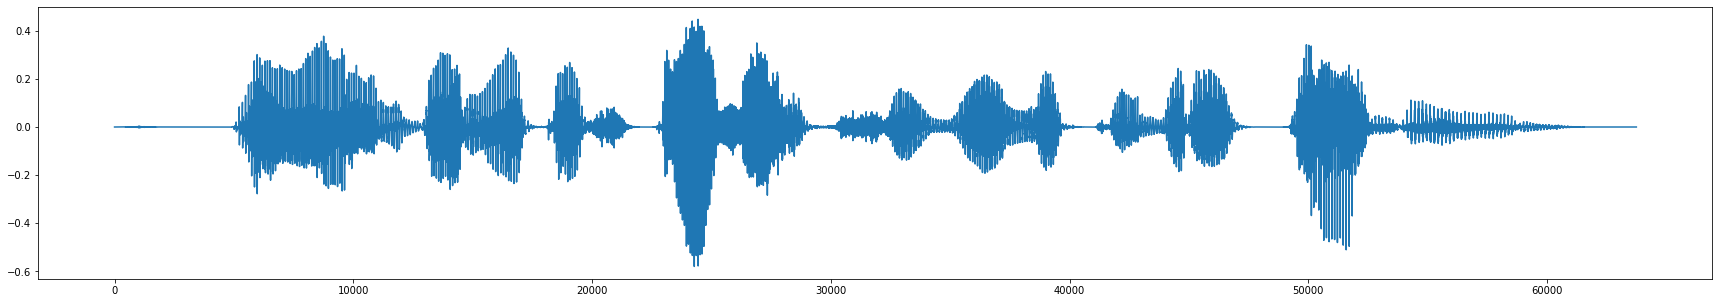

In [28]:
plt.figure(figsize=(30, 5))
plt.plot(wave);

Данные обычно представляются в формате float32 или int16. Нам нужно привести их к формату float32 с диапазоном значений [0, 1] (`примечание: преподаватели не предоставили обоснование/источник этой идеи!`). Стоит обратить внимание на максимальное и минимальное значения диапазона: если они близки к максимум и минимуму диапазона, возможно, они были нормализованы или даже клипированы.

In [29]:
# Pre-emphasis:
# y_t = x_t − α * x_t − 1
# α = 0.97


def preemphasis(x, coef=0.85):
    # Filter:
    y = x.copy()
    y[1:] -= coef * x[:-1]

    # Normalize:
    y -= y.min()
    y /= y.max()
    return y


preemh_wave = preemphasis(wave, 0.97)

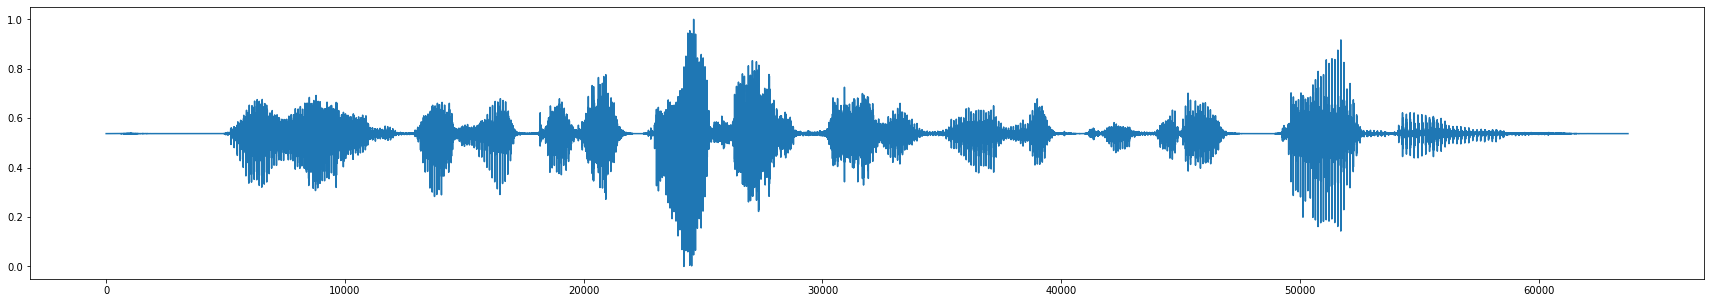

In [30]:
plt.figure(figsize=(30, 5))
plt.plot(preemh_wave);

Pre-emphasis — обратимое преобразование. Приводит к усилению высоких частот и ослаблению низких. В вокодерах необходимо для уменьшения высокочастотного шума при мю-кодировании.

In [31]:
# STFT (можно воспользоваться librosa)
# window = 1024, hop = 256, паддинг reflect, центрировать не надо, окно Ханна


def get_stft(data, n_fft, hop, window):
    return librosa.stft(
        data,
        n_fft=n_fft,
        hop_length=hop,
        window=window,
        center=False,
        pad_mode="reflect",
    )


stft_features = get_stft(wave, 1024, 256, "hann")

Short-time Fourier transform. Комплексные значения признаков. 

Окно анализа обычно соразмерно средней длине фонемы, шаг выбирается близким к средней длине коротких фонем (эвристические соображения, от которых стоит отталкиваться).

In [32]:
# Получаем амплитудный спектр.


def get_magnitude(features):
    return np.abs(features)


magnitude_features = get_magnitude(stft_features)

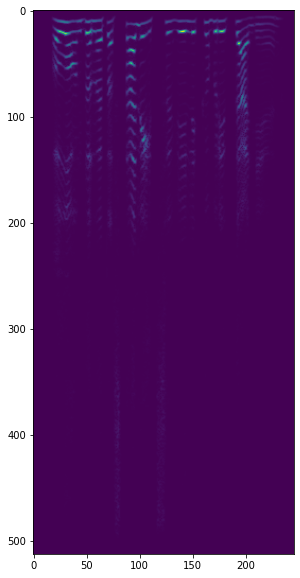

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(magnitude_features);

После такого преобразования теряется информация о фазе (фазовые признаки значительно менее структурированы). Признаки всё еще довольно большого размера, но в некоторых моделях TTS применяются и такие.

In [34]:
# Мел-скейл. Реализуется в матричном виде как X_mel = Mel_basis * X,
# где Mel_basis — 100 бинов без ограничений частот.


def get_mel_features(magnitude_features, mel_basis):
    return np.dot(mel_basis, magnitude_features)


def get_mel_basis(sample_rate, size):
    return librosa.filters.mel(sr=sample_rate, n_fft=1024, n_mels=size)


mel_basis = get_mel_basis(sr, 100)
mel_features = get_mel_features(magnitude_features, mel_basis)

In [35]:
print(f"max {mel_features.max()} " \
      f"min {mel_features.min()} " \
      f"mean {mel_features.mean()}")

max 1.3961414098739624 min 0.0 mean 0.02568608708679676


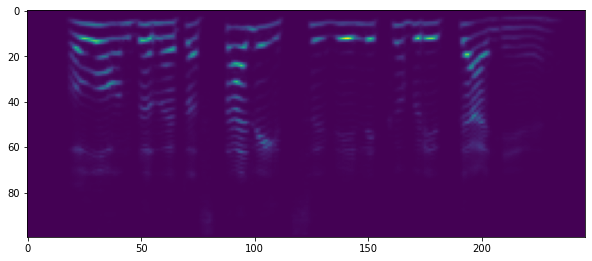

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(mel_features);

Значительно уменьшается размер признаков, при этом практически не теряется воспринимаемое акустическое качество.

In [37]:
# Логарифмирование.
# Амплитуды лучше логарифмировать через ln(x), 1e-5 установить
# минимальным значением под логарифмом (для вычислительной стабильности).
# Можно использовать и 20log10(x) (перевод в децибелы), но разница
# всего лишь в константе, поэтому можно не усложнять.


def get_log_features(features):
    return np.log(np.maximum(features, 1e-5))


log_mel_features = get_log_features(mel_features)

In [38]:
print(
    f"max {log_mel_features.max()} " \
    f"min {log_mel_features.min()} " \
    f"mean {log_mel_features.mean()}"
)

max 0.33371230959892273 min -11.512925148010254 mean -6.158172130584717


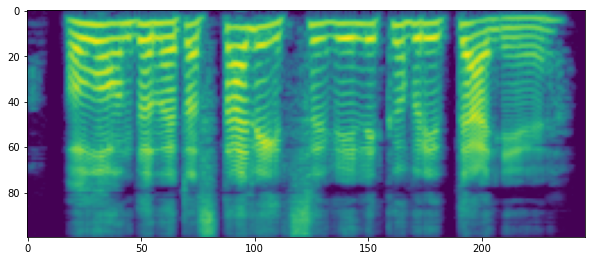

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(log_mel_features);

Такие признаки уже можно нормализовать.

Совет: посмотрите, как будут выглядеть эти же признаки без pre-emphasis.

In [40]:
# Выгрузим результат
np.save(f"log_mel_features_{my_id}.npy", log_mel_features)
# files.download(f"log_mel_features_{my_id}.npy")

### Задание 3

Механизм внимания позволяет модели отображать последовательность фонем на спектрограмму. Базовый вариант, предложенный в модели Tacotron 1, называется **Content-Based Attention**.

Этот простой механизм пришел в TTS из области машинного перевода, поэтому он не учитывает многих особенностей синтеза речи. В основном это **монотонный** и **локальный** характер внимания.

**Монотонность** обеспечивается тем, что порядок звуков и фонем одинаковый (если одна фонема находится в порядке после другой, то и её признаки в спектрограмме будут находиться после признаков первой, в отличие от задачи машинного перевода, где порядок слов в разных языках может отличаться).

**Локальность** обеспечивается тем, что фонемы влияют на звучание только своих ближайших соседей.

Не очень подходящий механзм внимания значительно влияет на качество и естественность речи. Непрерывные длинные участки речи с ним вообще крайне затруднительно синтезировать (внимание "ломается", "рассыпается", пропадают звуки, слова, речь заедает, звучит "белиберда", ломается голос, интонации).

Разработано уже много вариантов улучшения механизма внимания. А одни из лучших способов — сразу прогнозировать длительность фонем.

Попробуем на игрушечном примере построить один из рабочих вариантов механизма внимания **Forward Attention** (https://arxiv.org/pdf/1807.06736.pdf). 

In [41]:
seq_len = 100
enc_size = 32
attn_rnn_size = 16
dec_rnn_size = 16
attn_inner_size = 32
# у нас нет остановки, поэтому зададим заранее количество шагов декодера:
decoder_steps = 200

In [42]:
!gdown -q --id '1AygvvUXfj-TxEN2XQoUwU8NYKI4YyVLM'
!unzip -nq task1.zip encoder_output.npy decoder_state_dict.pt
!rm task1.zip

In [43]:
# загрузим заранее сгенерированный вектор
encoder_output = torch.from_numpy(np.load("encoder_output.npy"))

In [44]:
class Attention(torch.nn.Module):
    def __init__(self, query_size, key_size, attn_inner_size):
        super(Attention, self).__init__()
        self.softmax = torch.nn.Softmax(dim=0)
        self.query = torch.nn.Linear(query_size, attn_inner_size, bias=False)
        self.key = torch.nn.Linear(key_size, attn_inner_size, bias=False)
        self.v = torch.nn.Linear(attn_inner_size, 1, bias=False)

    def forward(self, queries, keys):
        keys = self.key(keys)
        queries = self.query(queries)
        attn = self.v(torch.tanh((queries + keys)).squeeze())
        attn = self.softmax(attn)
        return attn


class SimpleAttnDecoder(torch.nn.Module):
    def __init__(self, enc_size, attn_rnn_size, dec_rnn_size, attn_inner_size):
        super(SimpleAttnDecoder, self).__init__()
        self.attn_rnn_size = attn_rnn_size
        self.dec_rnn_size = dec_rnn_size
        self.enc_size = enc_size
        self.attention = Attention(attn_rnn_size, enc_size, attn_inner_size)
        self.rnn_attn = torch.nn.RNNCell(input_size=enc_size,
                                         hidden_size=attn_rnn_size)
        self.rnn_decoder = torch.nn.RNNCell(
            input_size=enc_size, hidden_size=dec_rnn_size
        )

    def forward(self, encoder_output, output_len):
        attention_matrix = []
        outputs = []
        attention_state = torch.zeros(1, self.attn_rnn_size).float()
        decoder_state = torch.zeros(1, self.dec_rnn_size).float()
        context = torch.zeros(1, self.enc_size).float()

        for idx in range(output_len):
            attention_state = self.rnn_attn(context, attention_state)
            attention_probs = self.attention(attention_state, encoder_output)
            # Forward Attention - это всего лишь модификация attention_probs.
            # Допишите класс SimpleAttnDecoder, чтобы в этом месте срабатывал
            # Forward Attention (algorithm 1 из предложенной статьи
            # без transition agent).
            ############################################################
            if idx == 0:  # initialize forward attention
                forward_attention = torch.zeros_like(attention_probs)
                forward_attention[0] = 1
            attention_probs *= forward_attention + torch.cat(
                (torch.zeros((1, 1)), forward_attention[:-1])
            )
            attention_probs /= torch.sum(attention_probs)
            forward_attention = attention_probs
            ############################################################
            context = torch.mm(
                encoder_output.squeeze().transpose(0, 1), attention_probs
            ).transpose(0, 1)
            decoder_state = self.rnn_decoder(context, decoder_state)

            attention_matrix.append(attention_probs)
            outputs.append(decoder_state)

        attention_matrix = torch.stack(attention_matrix).transpose(0, 1).squeeze()
        outputs = torch.stack(outputs).transpose(0, 1).squeeze()
        return outputs, attention_matrix

In [45]:
decoder = SimpleAttnDecoder(enc_size,
                            attn_rnn_size,
                            dec_rnn_size,
                            attn_inner_size)

decoder.load_state_dict(torch.load("decoder_state_dict.pt"))

<All keys matched successfully>

In [46]:
with torch.no_grad():
    outputs, attention_matrix = decoder(encoder_output, decoder_steps)

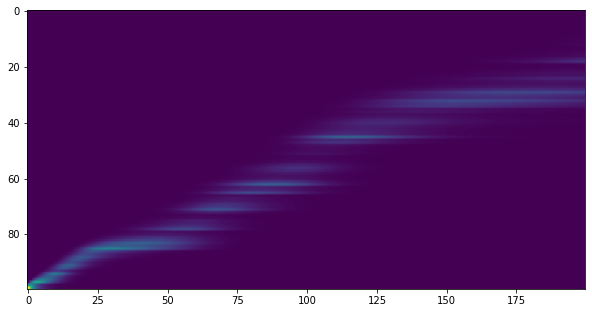

In [47]:
plt.figure(figsize=(10, 10))
plt.imshow(attention_matrix.flip(0));

In [48]:
# Выгрузим готовый результат (матрицу внимания с реализованным Forward Attention):
np.save(f"attention_{my_id}.npy", attention_matrix.flip(0).numpy())
# files.download(f"attention_{my_id}.npy")

Матрица внимания будет значительно диагональнее (и это модель со случайным входом и случайными весами!).